#### Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

2025-03-31 12:08:43.073790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743419323.124434    5329 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743419323.144268    5329 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743419323.239445    5329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743419323.239480    5329 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743419323.239482    5329 computation_placer.cc:177] computation placer alr

# Data Understanding

In [2]:
dataset_path = 'Dataset'
subsets = ['Training','Testing'] # Dataset divided into 2 subsets: training and testing

In [3]:
image_data = []

for subset in subsets: # goes through the 2 subsets training and testing
    subset_path = os.path.join(dataset_path,subset)
    diagnoses = os.listdir(subset_path) # Returns a list of diagnoses

    for diag in diagnoses: # iterates over the diagnoses
        diagnoses_folder = os.path.join(subset_path, diag )
        for img_file in os.listdir(diagnoses_folder):
            img_path = os.path.join(diagnoses_folder, img_file) # gets the image path within the diagnoses folder 
            with Image.open(img_path) as img: 
                width, height = img.size # Collects the width, height, and mode of the images
                mode = img.mode
                image_data.append({ # adds all the collected info for each image to the list
                    'subset':subset,
                    'diagnosis': diag,
                    'width': width,
                    'height': height,
                    'mode': mode,
                    'image': np.array(img) #image converted to numpy array
                })


df = pd.DataFrame(image_data)
    

In [4]:
df.head()

,subset,diagnosis,width,height,mode,image
0,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [5]:
# Number of images for training and testing for each diagnosis
table = df.groupby(['subset', 'diagnosis']).size().unstack()
table

diagnosis,glioma,meningioma,notumor,pituitary
subset,,,,
Testing,323,339,400,349
Training,1298,1339,1600,1408


In [6]:
df_train = df[df['subset'] == 'Training']
df_test = df[df['subset'] == 'Testing']

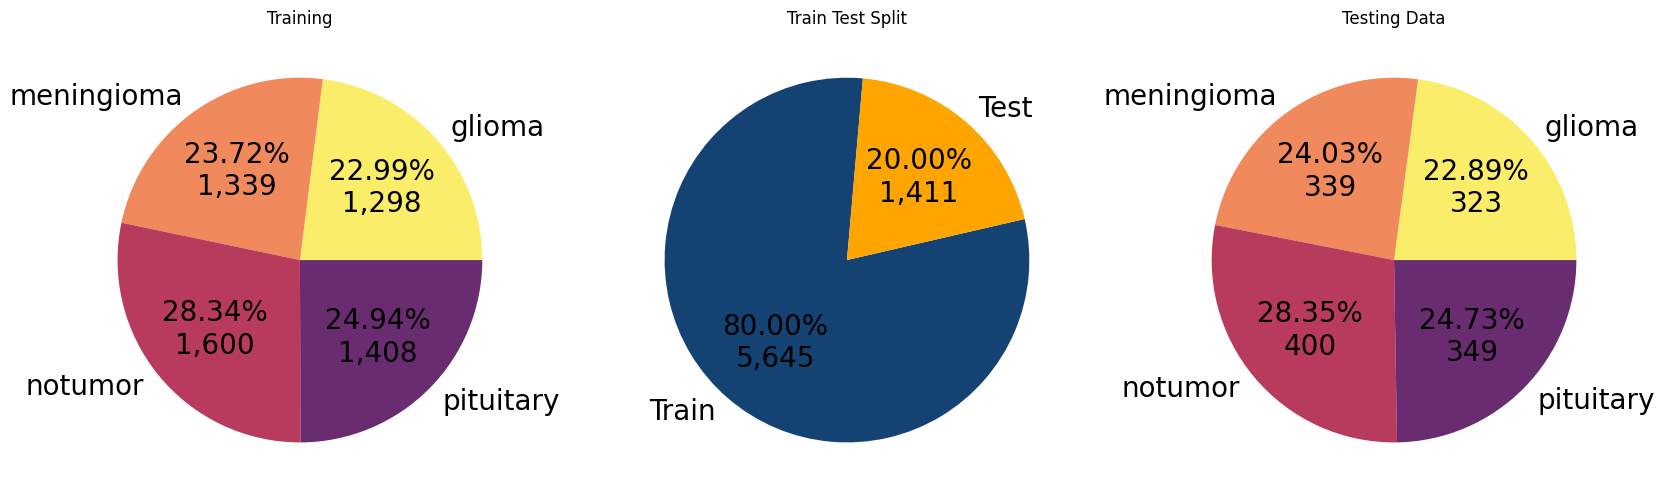

In [7]:
training_data = table.loc['Training'] 
testing_data= table.loc['Testing']

fig, ax = plt.subplots(ncols = 3,figsize=(20,14))

# training data split
ax[0].pie(training_data, labels= training_data.index,colors = ["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_train['diagnosis'].value_counts()) / 100),
    textprops={'fontsize': 20})
ax[0].set_title("Training")

# train test split
ax[1].set_title("Train Test Split")
ax[1].pie(
    [len(df_train), len(df_test)], 
    labels=['Train', 'Test'], 
    colors=['#144272', 'orange'],  # Fixed colors syntax and spelling
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * (len(df_train) + len(df_test)) / 100),
    startangle=85, 
    textprops={'fontsize': 20}
)

# testing data split
ax[2].set_title('Testing Data')
ax[2].pie(testing_data, labels= testing_data.index, colors=["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_test['diagnosis'].value_counts()) / 100),
    textprops={'fontsize': 20 })

plt.show()

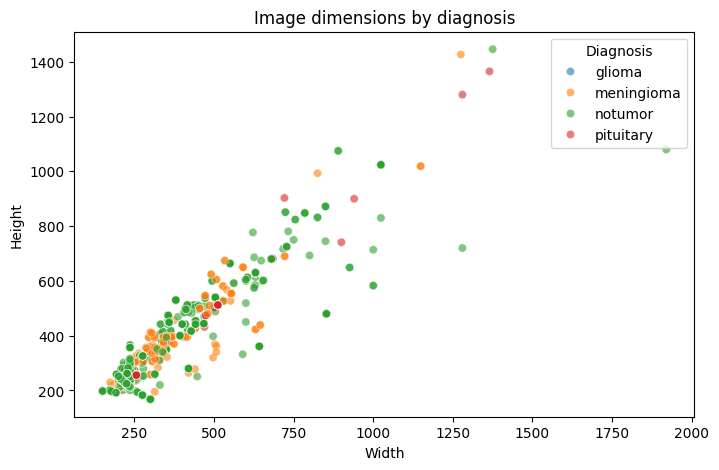

In [8]:
# Distribution of image dimensions 
plt.figure(figsize=(8,5))
sns.scatterplot(data = df, x='width',y='height', hue='diagnosis',alpha=0.6)
plt.title('Image dimensions by diagnosis')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(title='Diagnosis')
plt.show()

In [9]:
# Displaying the mode of images, shows inconsistency across images
df['mode'].value_counts()

mode
RGB     3952
L       3100
RGBA       3
P          1
Name: count, dtype: int64

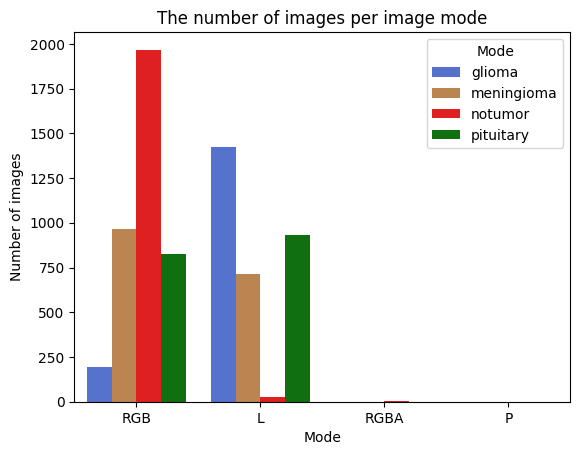

In [10]:
# The number
sns.countplot(data=df, x='mode', hue='diagnosis', palette=['royalblue', 'peru', 'red', 'green'],legend='full')
plt.title('The number of images per image mode')
plt.xlabel('Mode')
plt.ylabel('Number of images')
plt.legend(title='Mode')
plt.show()

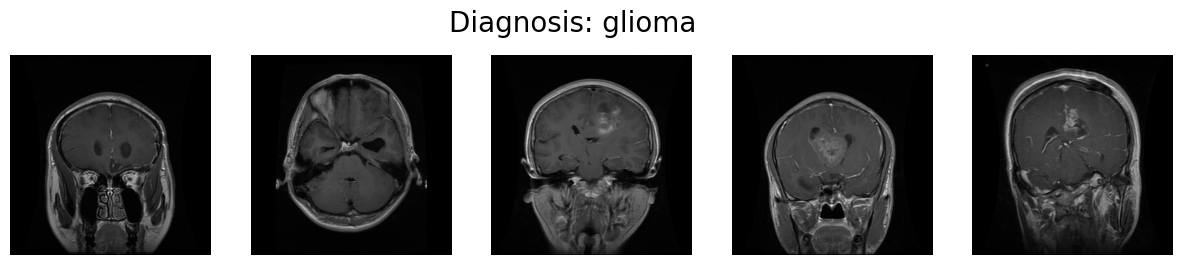

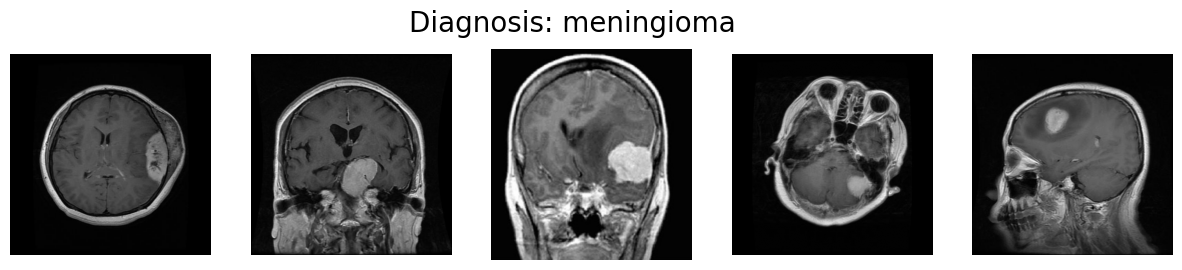

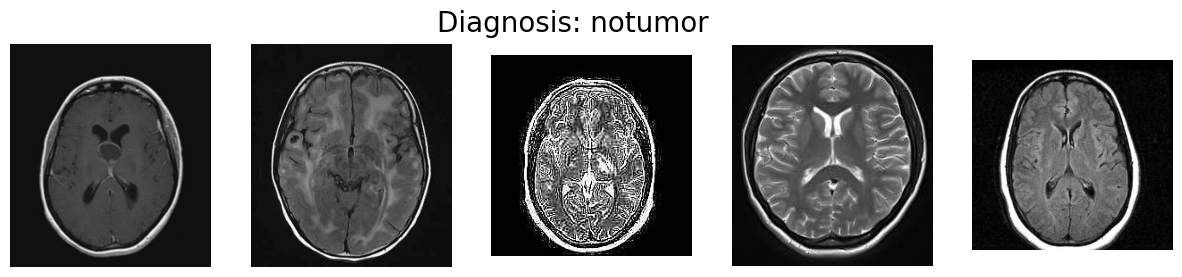

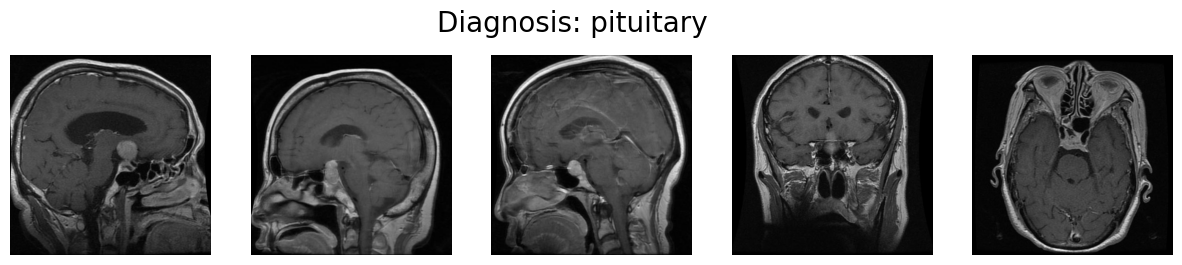

In [11]:
# Take 5 images from each diagnosis and visualise them, raw images without processing
for diag in diagnoses:
    samples = [item for item in image_data if item['diagnosis'] == diag]
    samples = random.sample(samples, k=5)  
    
    plt.figure(figsize=(15, 3))
    for i, item in enumerate(samples):
        plt.subplot(1, 5, i + 1)
        plt.imshow(item['image'],cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Diagnosis: {diag}",fontsize=20)
    plt.show()
    


## Findings
The brain tumors dataset consists of 4 different brain diagnoses: Glioma, meningioma, pituitary and healthy (known as notumor). There are 7023 images; 5712 for training (81.33%) and 1311 for testing (18.67%) divided closely between the four diagnoses, also each subset is well divided among the 4 classes with a maximum of 27.92% for healthy brain and a minimum of 23.13% for glioma in the training set, with nearly similar results for the testing set indicating a good class balance to start with.

However, the image dimensions by diagnosis chart shows a huge variance in image dimensions that needs to be handled as part of the data preparation, we need to choose a common image size for all the images which may affect the performance of the model as certain parts of the brain may/may not be taken when resizing especially when it comes to locating tumors within the brain. Also the fact that some images have different color modes (3926 RGB and 3093 Greyscale) so we need to ensure consistency among shapes and channels to avoid potential issues.

# Data Preparation

In [12]:
train_dir = 'Dataset/Training' # train images directory
test_dir = 'Dataset/Testing'  # test images directory
batch_size= 32 # define batch size
image_size = 224 # define image size

In [13]:
#load training data using image_dataset_from_directory
#source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,                                     
    label_mode= 'int',                             # Labels are encoded as a integers
    validation_split= 0.2,                         # 20% of the training data will be used for training
    color_mode = 'rgb',                            # Load all images in RGB mode 
    batch_size = batch_size,                       # number of images processed in each batch
    image_size = (image_size,image_size),          # image size is 224x224 (this will fix the imbalance we plotted earlier by using a uniform size)
    seed = 111,
    subset = 'training'                            # Training subset
)

#load validation data using image_dataset_from_directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode= 'int',
    validation_split= 0.2,
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (image_size,image_size),
    shuffle = False,                                # Validation data isn't shuffled
    seed = 111,
    subset = 'validation'                           # Validation subset
)

#load validation data using image_dataset_from_directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode= 'int',
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (image_size, image_size)
)

Found 5645 files belonging to 4 classes.
Using 4516 files for training.


I0000 00:00:1743419364.395811    5329 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5645 files belonging to 4 classes.
Using 1129 files for validation.
Found 1411 files belonging to 4 classes.


In [14]:
# Data augmentation
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),                                                             # Randomly flips images horizontally
    layers.RandomRotation(0.03,fill_mode='constant'),                                            # Randomly rotates images by ±10 degrees
    layers.RandomContrast(0.1),                                                                  # Randomly adjusts contrast by ±10%
    layers.RandomZoom(height_factor=0.01, width_factor=0.05),                                    # Randomly zooms in/out up to 1% vertically and 5% horizontally
    layers.RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),   # Randomly shifts the image by 0.15% of the height and width
   
])

rescale = layers.Rescaling(1./255)  # Rescale pixel values to [0, 1] range

In [15]:
# Source: https://www.tensorflow.org/tutorials/images/data_augmentation

AUTOTUNE = tf.data.AUTOTUNE # Allows TensorFlow to automatically choose the optimal number of parallel threads to improve performance

# training data augmented and rescaled (Images were already resized when loaded so we don't need to resize again)
train_ds = train_ds.map(
    lambda x, y: (rescale(data_augmentation(x,training= True)), y),
    num_parallel_calls= AUTOTUNE
)

# Validation data rescaled only
val_ds = val_ds.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls= AUTOTUNE
)

# Testing data rescaled only
test_ds = test_ds.map(
    lambda x, y: (rescale(x), y),
    num_parallel_calls= AUTOTUNE
)

# Allows later elements to be prepared while the current element is being processed which improves performance
train_ds_preprocessed = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_preprocessed = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds_preprocessed = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
def visualize_augmentation(data, diagnoses, num_samples):
    
    # empty dictionary that will contain an image per diagnosis
    diagnoses_images = {diag: None for diag in range(len(diagnoses))}
    
    # Unbatch data and get individual images
    for image, label in data.unbatch().shuffle(1000):
        label = int(label.numpy()) # convert tensorflow label to a python integer
        if diagnoses_images[label] is None:  # If we didn't store an image
            img = (image.numpy() * 255).astype(np.uint8) # convert image to an array and we scale it back to 0-255 (img_size = 224)
            diagnoses_images[label] = img # we add the image to the dictionary
       
            
    
    # Create visualization grid
    num_diagnoses = len(diagnoses) 
    fig, axes = plt.subplots(
        num_diagnoses,
        num_samples + 1,
        figsize=(2.5*(num_samples+1), 2.5*num_diagnoses))
    
    for class_idx in range(num_diagnoses):
        # Original image taken earlier
        orig_img = diagnoses_images[class_idx]
        # Add it in the first column of each row 
        axes[class_idx, 0].imshow(orig_img)
        axes[class_idx, 0].set_title(f"Original\n{diagnoses[class_idx]}")
        axes[class_idx, 0].axis('off')
        
        for aug_idx in range(1, num_samples+1):
            # We augment the original images 
            aug_img = data_augmentation(tf.expand_dims(orig_img, 0))
            aug_img = aug_img[0].numpy().astype('uint8')

            # then we add it to the visualisation grid
            axes[class_idx, aug_idx].imshow(aug_img)
            axes[class_idx, aug_idx].set_title(f"Augmented image {aug_idx}")
            axes[class_idx, aug_idx].axis('off')
    
    plt.tight_layout()
    plt.show()


2025-03-31 12:09:37.754719: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


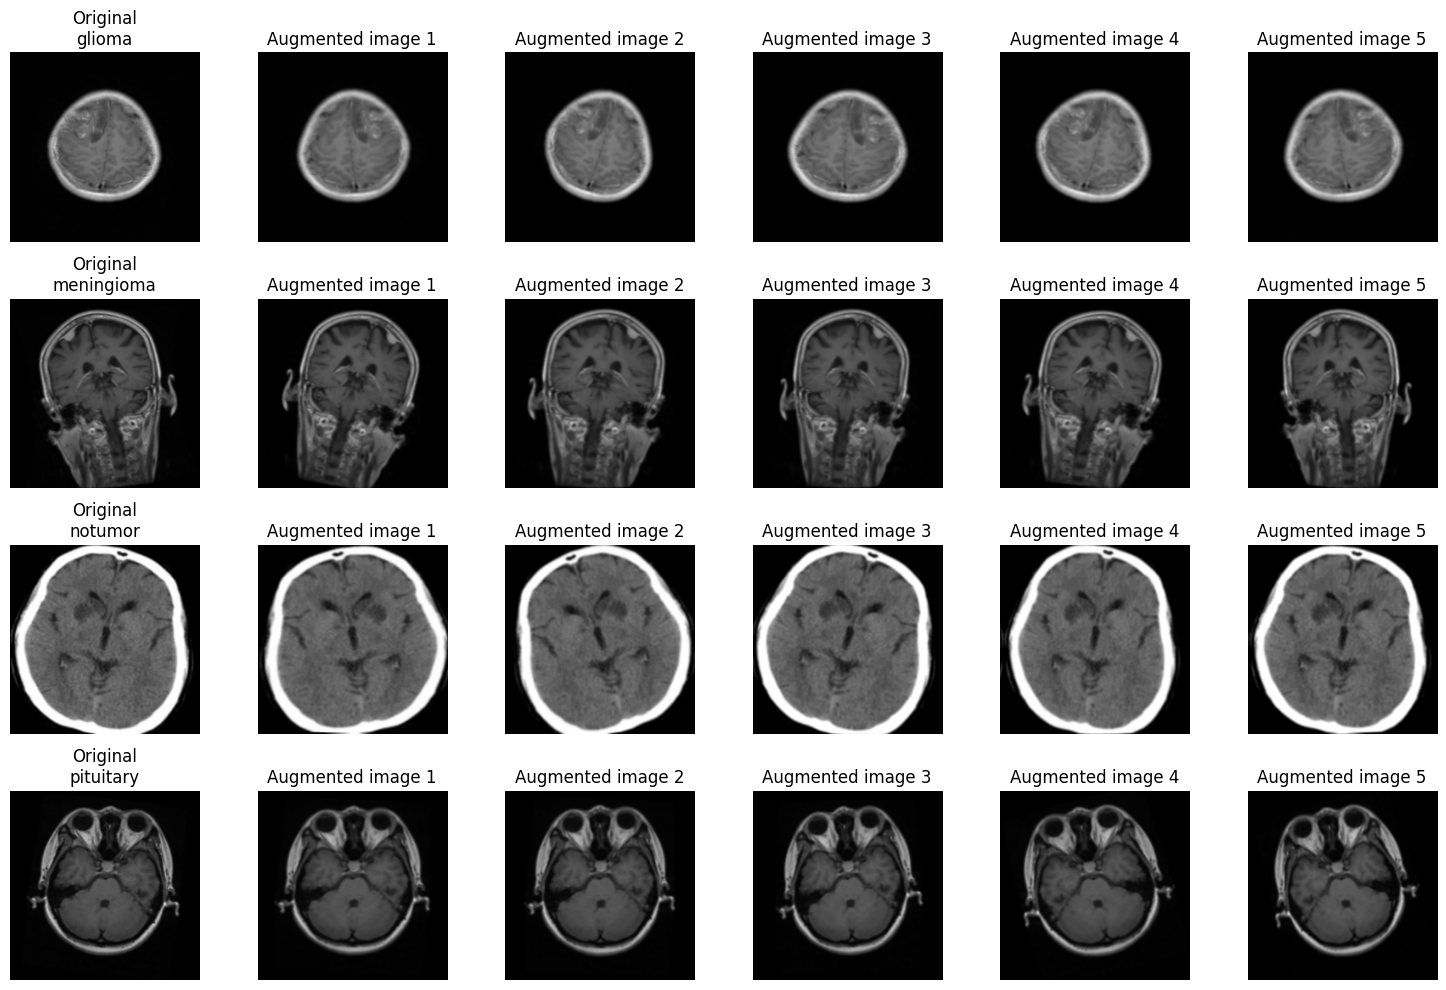

In [17]:
visualize_augmentation(
    data=train_ds,
    diagnoses = diagnoses,  
    num_samples=5
)